## BTO ヒステリシス曲線

## 前処理

BTO のヒステリシス曲線の測定データを処理するコード

まずはライブラリのインポートから

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import Normalize

ファイル名と温度・電圧の対応

In [3]:
temp = []
volt = []
# 室温から120度までのデータ
for i in range(4):
    for j in range(17):
        if (i == 0):
            temp.append(26.9)
        elif (i ==  1):
            temp.append(60.0)
        elif (i == 2):
            temp.append(90.0)
        elif (i == 3):
            temp.append(120.0)
        volt.append((j+1)*10.0)
# 125度からのデータ
for i in range(69, 102):
    volt.append(170)
# 温度は手打ち
temp.append(125)
temp.append(130)
temp.append(132)
temp.append(135)
temp.append(137)

temp.append(140)
temp.append(145)
temp.append(150)
temp.append(155)
temp.append(160)

temp.append(165)
temp.append(170)

temp.append(170)
temp.append(165)

temp.append(160)
temp.append(155)
temp.append(150)
temp.append(145)
temp.append(140)

temp.append(137)
temp.append(135)
temp.append(132)
temp.append(130)
temp.append(125)

temp.append(120)
temp.append(115)
temp.append(110)

temp.append(105)
temp.append(100)
temp.append(95)
temp.append(90)
temp.append(85)

temp.append(80)

temp = np.array(temp)
volt = np.array(volt)

heating_index = [16, 33, 50, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
cooling_index = list(range(80,101))

csv ファイルのインポート。
データフレームにした後、電圧だけを取り出して、x 軸に電場、y軸に電束密度にする。
BTO を入れたコンデンサのパラメータ、厚さを thin 面積を area としてる。

In [4]:
thin = 500                  # マイクロメートル
area = 20                   # 平方ミリメートル
epsilon0 = 0.88541878188    # 真空の誘電率 nF/cm

csv からデータを読み取とり、data 変数に入れる

data[何番目のファイル][i][成分]

i = 0 時刻、 i = 1 電場, i = 2 分極、i = 3 電圧、 i = 4 温度

In [5]:
nfile = 101
data = np.zeros((nfile, 5, 10000))
for i in range(1, nfile+1):
    df = pd.read_csv(f"2024_10_04_BTO/ALL{i:04}.CSV", skiprows=24, usecols = [0,1,3])
    data[i-1][0][:] = df.iloc[:,0].values
    data[i-1][1][:] = df.iloc[:,1].values / thin * 100 # kV/cm
    data[i-1][2][:] = df.iloc[:,2].values / area * 10  # uC/cm^2
    data[i-1][3][:] = volt[i-1]
    data[i-1][4][:] = temp[i-1]

# 移動平均によるフィルターと平均からのずれの補正
window_size = 100
for i in range(nfile):
    Emean = np.mean(data[i][1][:])
    Pmean = np.mean(data[i][2][:])
    for j in range(0, 10000-window_size):
        data[i][1][j] = np.mean(data[i][1][j:j+window_size]) - Emean
        data[i][2][j] = np.mean(data[i][2][j:j+window_size]) - Pmean

関数のフィッティングをする。
常誘電相では
$$
 f(T) = A(T-T_c)^a +B
$$
強誘電相では
$$
 f(T) = A(T_c-T)^a +B
$$
としてフィッティングする。

In [6]:
def parafit(x, Tc, A, B, a):
    return A* ((x-Tc)*(x-Tc))**(a/2) + B

def ferofit(x, Tc, A, B, a):
    return A* (Tc-x)**a + B

## 解析

### 降伏電場

正の方の降伏電場と負の方の降伏電場、合わせて5個の平均をとる。
降伏電場の選び方としては単純に D が最も 0 に近いときの E の値を選ぶという方法をとる。

ただし、かけた電場が弱いとオシロスコープの分解能が対応しないため信用ならない値となる。

In [39]:
Ec = np.zeros(nfile)
for i in range(nfile):
    Ec[i] += data[i][1][np.argmin(np.abs(data[i][2][0:2000]))]
    Ec[i] -= data[i][1][np.argmin(np.abs(data[i][2][2000:4000]))+2000]
    Ec[i] += data[i][1][np.argmin(np.abs(data[i][2][4000:6000]))+4000]
    Ec[i] -= data[i][1][np.argmin(np.abs(data[i][2][6000:8000]))+6000]
    Ec[i] += data[i][1][np.argmin(np.abs(data[i][2][8000:10000]))+8000]
    Ec[i] /= 5

温度依存性

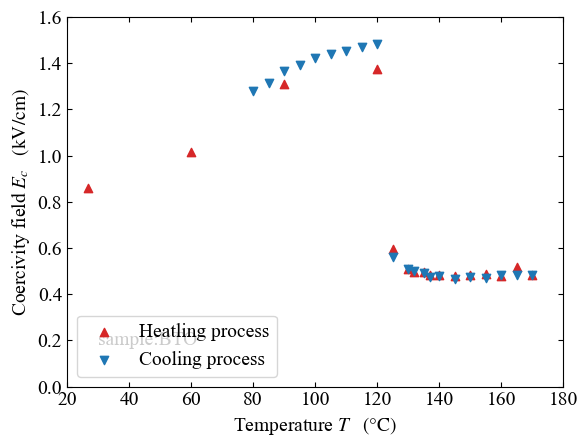

In [43]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,180)
plt.ylim(0,1.6)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{(\degree C)}$")
plt.ylabel("Coercivity field $ E_c \quad(\mathrm{kV/cm)}$ ")

# プロット
plt.scatter(temp[heating_index],Ec[heating_index], color = "tab:red", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],Ec[cooling_index], color = "tab:blue", marker = "v", label = "Cooling process")

plt.legend(loc = "lower left")
# その他要素
plt.text(30, 0.18, "sample:BTO", backgroundcolor = "white")
# plt.annotate(text='cooling',xy=(75,0.8),xytext=(85,0.85), arrowprops=dict(color='tab:blue', width =2.0,headwidth=7.0,headlength=7.0,shrink=0.01))
# plt.annotate(text='heating',xy=(100,0.67),xytext=(70,0.6), arrowprops=dict(color='tab:red', width =2.0,headwidth=7.0,headlength=7.0,shrink=0.01))


plt.show()

強誘電相での電圧依存性

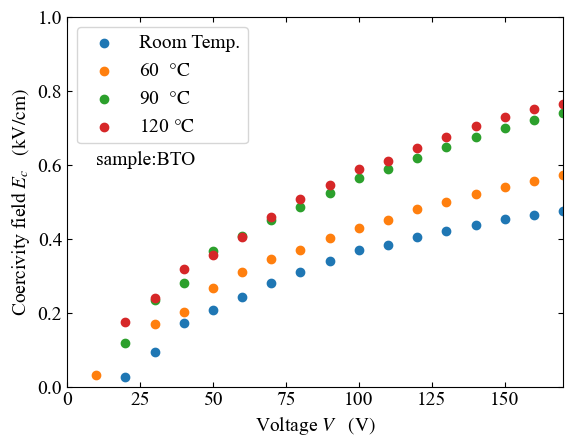

In [9]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(0,170)
plt.ylim(0,1)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Voltage $ V \quad\mathrm{(V)}$")
plt.ylabel("Coercivity field $ E_c \quad(\mathrm{kV/cm)}$ ")

# プロット
plt.scatter(volt[ 0:17],Ec[ 0:17], label = "Room Temp.")
plt.scatter(volt[17:34],Ec[17:34], label = "60  $\mathrm{\degree C}$")
plt.scatter(volt[34:51],Ec[34:51], label = "90  $\mathrm{\degree C}$")
plt.scatter(volt[51:68],Ec[51:68], label = "120 $\mathrm{\degree C}$")

# 凡例
plt.legend()

# その他要素
plt.text(10, 0.6, "sample:BTO", backgroundcolor = "white")

plt.show()

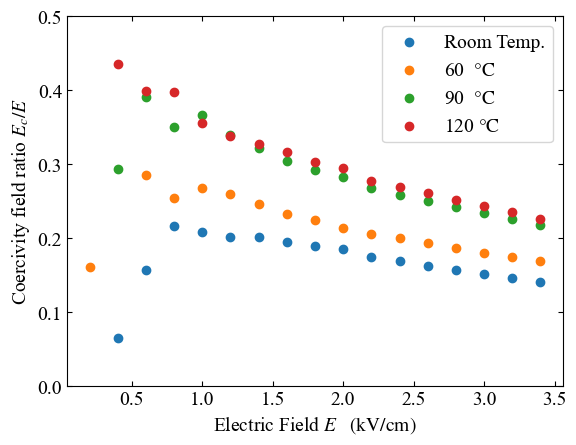

In [10]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
# plt.xlim(0,170)
plt.ylim(0,0.5)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric Field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Coercivity field ratio $ E_c/E$ ")

# プロット
plt.scatter(volt[ 0:17] / thin * 10,Ec[ 0:17]/(volt[ 0:17] / thin * 10), label = "Room Temp.")
plt.scatter(volt[17:34] / thin * 10,Ec[17:34]/(volt[17:34] / thin * 10), label = "60  $\mathrm{\degree C}$")
plt.scatter(volt[34:51] / thin * 10,Ec[34:51]/(volt[34:51] / thin * 10), label = "90  $\mathrm{\degree C}$")
plt.scatter(volt[51:68] / thin * 10,Ec[51:68]/(volt[51:68] / thin * 10), label = "120 $\mathrm{\degree C}$")

# 凡例
plt.legend()

# その他要素
# plt.text(10, 0.6, "sample:BTO", backgroundcolor = "white")

plt.show()

### ヒステリシスロス

2次元閉曲線を表す点群の内部の面積を数値計算で求める方法として、**多角形の面積を計算するアルゴリズム**がよく使われます。特に、**シュー・レーシング（shoelace formula）**、または**ガウスの面積公式**が便利です。これにより、点群で定義された閉曲線の面積を効率的に計算することができます。

手順は次の通りです：

1. 点群の順序を定義
点群が $(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)$ で与えられているとします。この点群が閉曲線を定義しているので、最初の点と最後の点は一致しない場合、最初の点に戻るように点を追加して閉じる必要があります。

2. シュー・レーシング公式の適用
点群を使って、面積 $A$ を以下の式で計算します。

$$
A = \frac{1}{2} \left| \sum_{i=1}^{n} (x_i y_{i+1} - y_i x_{i+1}) \right|
$$

ここで、$ (x_{n+1}, y_{n+1}) $ は $ (x_1, y_1) $ です。


3. 注意点
- 点群が時計回りか反時計回りかによって面積の符号が変わることがありますが、絶対値をとることで正の面積を得られます。
- 曲線が複雑な場合や凹凸がある場合は、点群の順序に注意が必要です。

In [11]:
hysterisis_loss = np.zeros(nfile)
for i in range(nfile):
    temp_area = 0
    x1 = data[i][1][0:8000]
    y1 = data[i][2][0:8000]
    x2 = data[i][1][1:8001]
    y2 = data[i][2][1:8001]
    hysterisis_loss[i] = np.abs(np.dot(x1, y2) - np.dot(y1, x2))/4

温度依存性

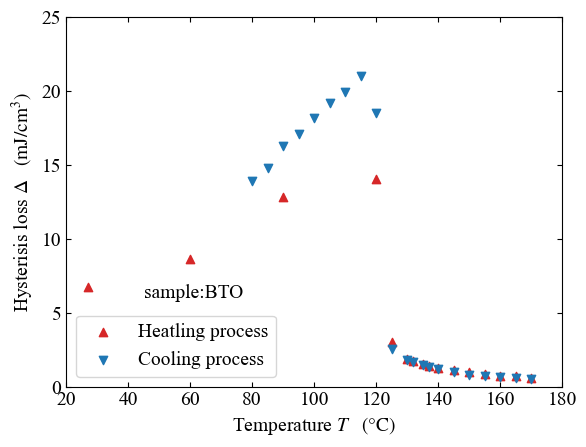

In [12]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,180)
plt.ylim(0,25)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{(\degree C)}$")
plt.ylabel("Hysterisis loss $ \Delta \quad(\mathrm{mJ/cm^3)}$ ")

# プロット
plt.scatter(temp[heating_index],hysterisis_loss[heating_index], color = "tab:red", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],hysterisis_loss[cooling_index], color = "tab:blue", marker = "v", label="Cooling process")

plt.legend(loc = "lower left")
# その他要素
plt.text(45, 6, "sample:BTO")
# plt.annotate(text='cooling',xy=(65,15.6),xytext=(75,18), arrowprops=dict(color='tab:blue', width =2.0,headwidth=7.0,headlength=7.0,shrink=0.01))
# plt.annotate(text='heating',xy=(100,11.2),xytext=(70,8), arrowprops=dict(color='tab:red', width =2.0,headwidth=7.0,headlength=7.0,shrink=0.01))


plt.show()

電圧依存性

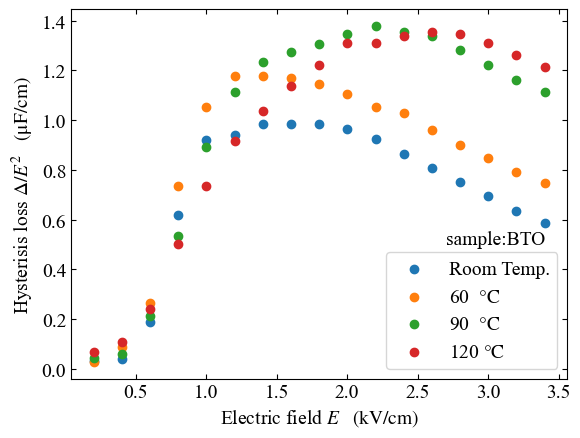

In [13]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
# plt.xlim(0,170)
# plt.ylim(0,15)

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Hysterisis loss $ \Delta / E^2\quad(\mathrm{\mu F/cm)}$ ")

# プロット
plt.scatter(volt[ 0:17]/ thin * 10,hysterisis_loss[ 0:17]/(volt[ 0:17]/ thin * 10)**2, label = "Room Temp.")
plt.scatter(volt[17:34]/ thin * 10,hysterisis_loss[17:34]/(volt[17:34]/ thin * 10)**2, label = "60  $\mathrm{\degree C}$")
plt.scatter(volt[34:51]/ thin * 10,hysterisis_loss[34:51]/(volt[34:51]/ thin * 10)**2, label = "90  $\mathrm{\degree C}$")
plt.scatter(volt[51:68]/ thin * 10,hysterisis_loss[51:68]/(volt[51:68]/ thin * 10)**2, label = "120 $\mathrm{\degree C}$")

# 凡例
plt.legend()
plt.text(2.7, 0.5, "sample:BTO")

plt.show()

### 自発分極（ヒステリシスロスからの推定）

理想的なヒステリシス曲線は平行四辺形になっている。
そしてその面積$\Delta$は自発分極 $P_s$ と降伏電場電場 $E_c$ を用いて
$$
 \Delta = 4  P_s E_c
$$
となる。

実際の系では磁区構造や結晶粒、格子欠陥等でヒステリシス曲線が舐めるが、
このヒステリシスロスというのは分極の向きを全部ひっくり返すのに必要なエネルギーのことであるので、
実際の系と理想的な系での値は同じになるはず。

さらに降伏電場はなぜか実験でも理想的なときと同じ値になるらしい。
よって、面倒な外挿法を使わずとも計算できる（はず）

In [14]:
Ps_h = hysterisis_loss / Ec / 4

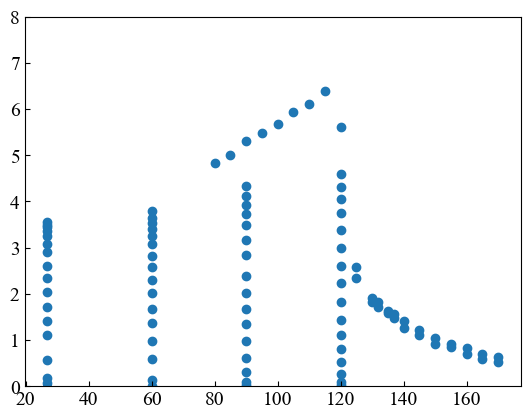

In [15]:
plt.ylim(0,8)
plt.scatter(temp,Ps_h)

### 自発分極（飽和磁化からの外挿）

実験で指示があった飽和分極付近での傾きを使って外挿する方法である。
飽和分極付近では強誘電性による分極が終わり他の常誘電てきな応答によるものしかないとみなす。
するとこの傾きは常誘電性の感受率になるので、ここ付近の値を線形近似し、
y軸での値を読み取るとそれは自発分極による寄与だとみなせる。

式で説明すると
誘電体中の電束密度は自発分極 $P_s$ と
常誘電的な $P(E) = \varepsilon_0\chi E$ の2つを用いて
$$
    D = \varepsilon_0 E + P(E) + P_s = \varepsilon_0 (1 + \chi)E + P_s 
$$
と書ける。飽和磁化付近では$P_s$は一定であるため、
線形近似したときの傾きは $\varepsilon_0(1+\chi)$となる。
なので直線を外挿して$E=0$での$D$の値を読むとそれが自発分極であるというのがわかる。

かけた電場が折り返す地点はわかるのでそこから polyfit 使って線形近似で残留分極を求める。

In [16]:
k = 151
Ps = np.zeros(nfile)
for i in range(nfile):
    k1 = np.argmin(data[i][1][0:1000])
    a1 = np.polyfit(data[i][1][k1:k1+k], data[i][2][k1:k1+k], 1)[1]

    k2 = np.argmax(data[i][1][1000:3000])
    a2 = np.polyfit(data[i][1][1000+k2:1000+k2+k], data[i][2][1000+k2:1000+k2+k], 1)[1]

    k3 = np.argmin(data[i][1][3000:5000])
    a3 = np.polyfit(data[i][1][3000+k3:3000+k3+k], data[i][2][3000+k3:3000+k3+k], 1)[1]

    k4 = np.argmax(data[i][1][5000:7000])
    a4 = np.polyfit(data[i][1][5000+k4:5000+k4+k], data[i][2][5000+k4:5000+k4+k], 1)[1]

    k5 = np.argmin(data[i][1][7000:9000])
    a5 = np.polyfit(data[i][1][7000+k5:7000+k5+k], data[i][2][7000+k5:7000+k5+k], 1)[1]

    Ps[i] = (-a1 + a2 - a3 + a4 - a5)/5

In [45]:
Ps_h = hysterisis_loss / Ec / 4

温度依存性

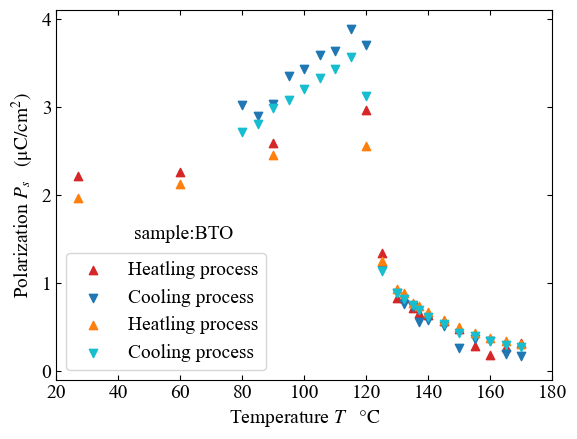

In [48]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,180)
plt.ylim(-0.1,4.1)
plt.yticks([0, 1, 2, 3, 4])

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Temperature $ T \quad\mathrm{\degree C}$")
plt.ylabel("Polarization $ P_s \quad\mathrm{(\mu C/cm^2)}$")

# プロット
plt.scatter(temp[heating_index],Ps[heating_index], color = "tab:red", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],Ps[cooling_index], color = "tab:blue", marker = "v", label="Cooling process")
plt.scatter(temp[heating_index],Ps_h[heating_index], color = "tab:orange", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],Ps_h[cooling_index], color = "tab:cyan", marker = "v", label="Cooling process")

plt.legend(loc = "lower left")
# その他要素
plt.text(45, 1.5, "sample:BTO")


plt.show()

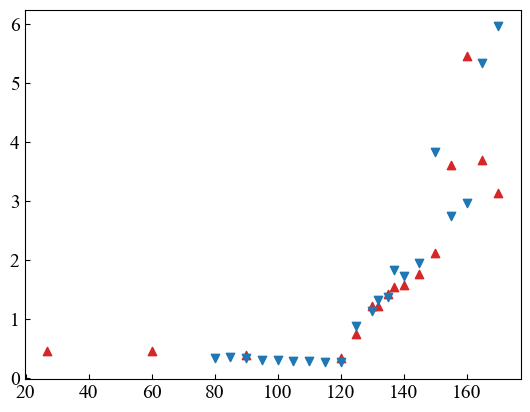

In [18]:
plt.scatter(temp[heating_index],1/Ps[heating_index], color = "tab:red", marker = "^", label = "Heatling process")
plt.scatter(temp[cooling_index],1/Ps[cooling_index], color = "tab:blue", marker = "v", label="Cooling process")

電圧依存性(TGSでは調べてない)

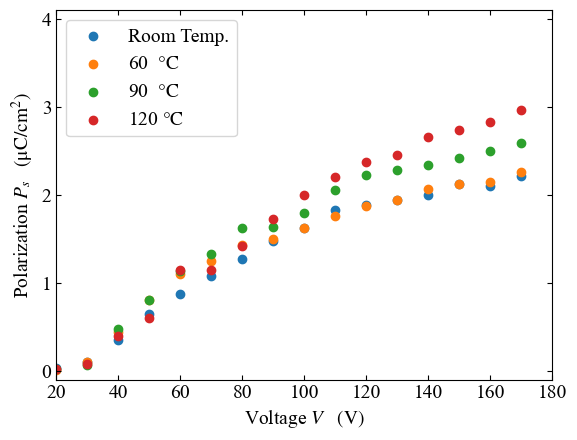

In [19]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(20,180)
plt.ylim(-0.1,4.1)
plt.yticks([0, 1, 2, 3, 4])

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Voltage $ V \quad\mathrm{(V)}$")
plt.ylabel("Polarization $ P_s \quad\mathrm{(\mu C/cm^2)}$")

# プロット
plt.scatter(volt[ 0:17], Ps[ 0:17], label = "Room Temp.")
plt.scatter(volt[17:34], Ps[17:34], label = "60  $\mathrm{\degree C}$")
plt.scatter(volt[34:51], Ps[34:51], label = "90  $\mathrm{\degree C}$")
plt.scatter(volt[51:68], Ps[51:68], label = "120 $\mathrm{\degree C}$")

# 凡例
plt.legend()

plt.show()

### スケーリング則

スケーリング則とかで調べることになる電気感受率等を計算する。

In [20]:
epsilon = np.zeros(nfile)
for i in range(nfile):
    for j in range(5):
        k = np.argmin(np.abs(data[i][1][j*2000:(j+1)*2000]))
        k1 = np.polyfit(data[i][1][j*2000+k-100:j*2000+k+100],data[i][2][j*2000+k-100:j*2000+k+100],1)[0]
        epsilon[i] += k1
chi = epsilon/(epsilon0*5)
epsilon = epsilon/5

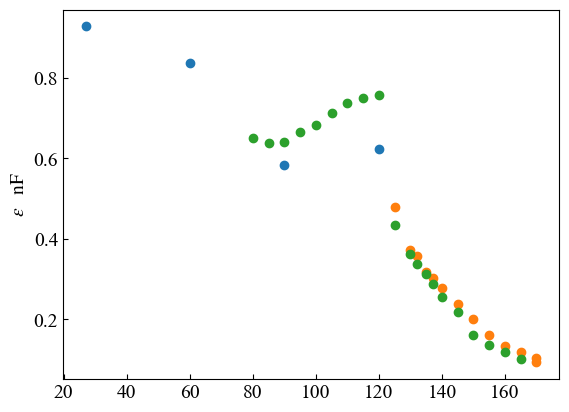

In [21]:
plt.ylabel("$\epsilon \quad\mathrm{nF}$")
plt.scatter(temp[16:68:17],epsilon[16:68:17])
plt.scatter(temp[68:81],epsilon[68:81])
plt.scatter(temp[81:],epsilon[81:])

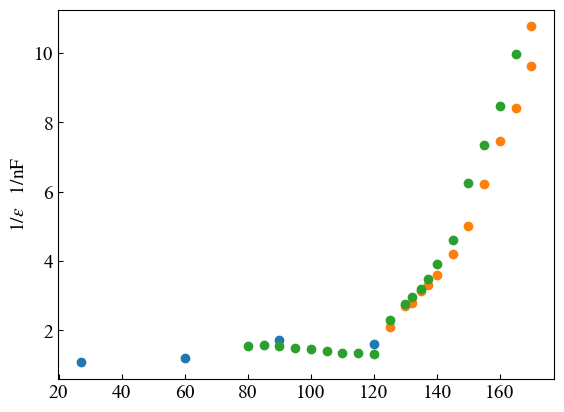

In [44]:
plt.ylabel("$1/\epsilon \quad\mathrm{1/nF}$")
plt.scatter(temp[16:68:17],1/epsilon[16:68:17])
plt.scatter(temp[68:81],1/epsilon[68:81])
plt.scatter(temp[81:],1/epsilon[81:])

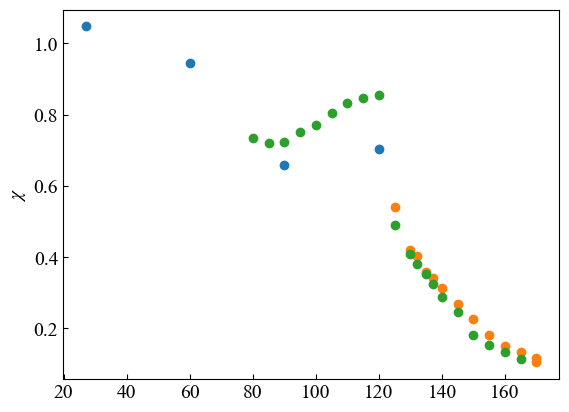

In [23]:
plt.ylabel("$\chi$")
plt.scatter(temp[16:68:17],chi[16:68:17])
plt.scatter(temp[68:81],chi[68:81])
plt.scatter(temp[81:],chi[81:])

## プロット

### 電圧依存性

室温

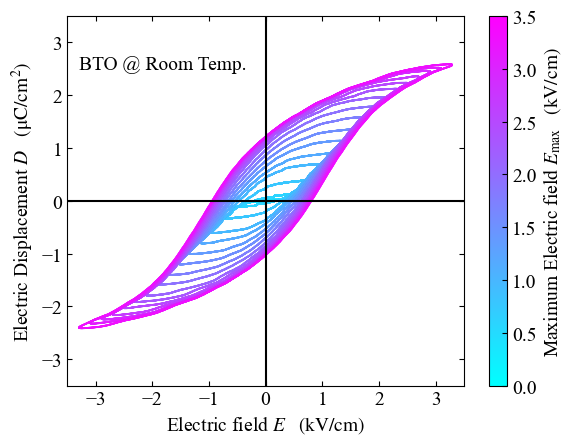

In [24]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(0,17):
    EField = np.max(data[i][1][3000:7000])
    EField_list = np.full(10000, EField)
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=EField_list[3000:7000], cmap="cool", norm=Normalize(vmin=0, vmax=3.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-3.3, 2.5, "BTO @ Room Temp.", backgroundcolor = "white")

plt.show()


60 ℃

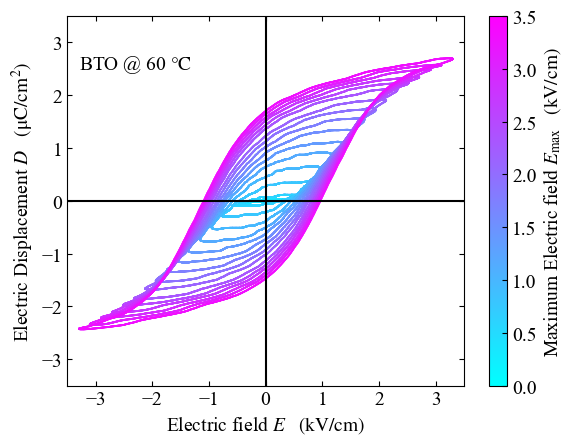

In [25]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(17,34):
    EField = np.max(data[i][1][3000:7000])
    EField_list = np.full(10000, EField)
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=EField_list[3000:7000], cmap="cool", norm=Normalize(vmin=0, vmax=3.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-3.3, 2.5, "BTO @ 60 $\mathrm{\degree C}$", backgroundcolor = "white")

plt.show()

90 ℃

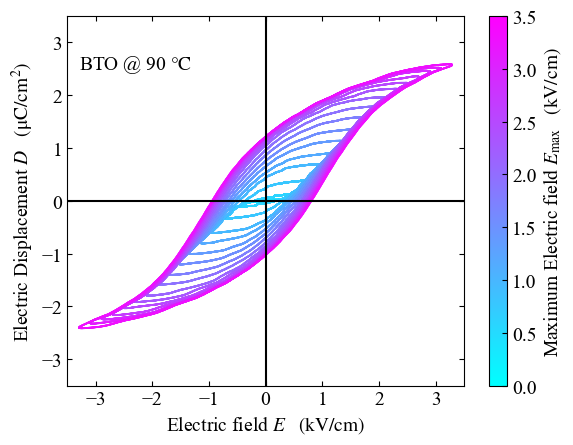

In [26]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(0,17):
    EField = np.max(data[i][1][3000:7000])
    EField_list = np.full(10000, EField)
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=EField_list[3000:7000], cmap="cool", norm=Normalize(vmin=0, vmax=3.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-3.3, 2.5, "BTO @ 90 $\mathrm{\degree C}$", backgroundcolor = "white")

plt.show()

120 ℃

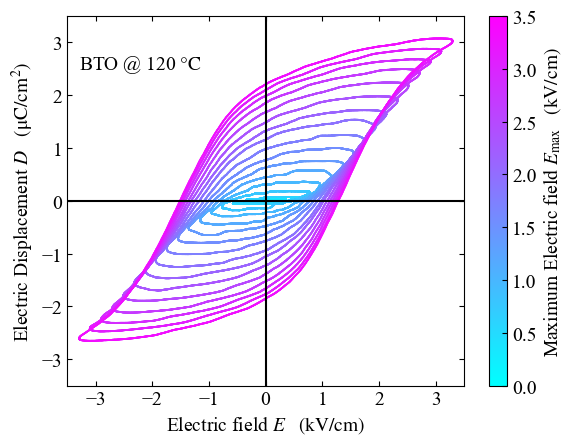

In [27]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-3.5,3.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(51,68):
    EField = np.max(data[i][1][3000:7000])
    EField_list = np.full(10000, EField)
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=EField_list[3000:7000], cmap="cool", norm=Normalize(vmin=0, vmax=3.5),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Maximum Electric field $ E_{\mathrm{max}} \quad\mathrm{(kV/cm)}$")
# その他要素
plt.text(-3.3, 2.5, "BTO @ 120 $\mathrm{\degree C}$", backgroundcolor = "white")

plt.show()

### 温度依存性

相転移付近の昇温過程

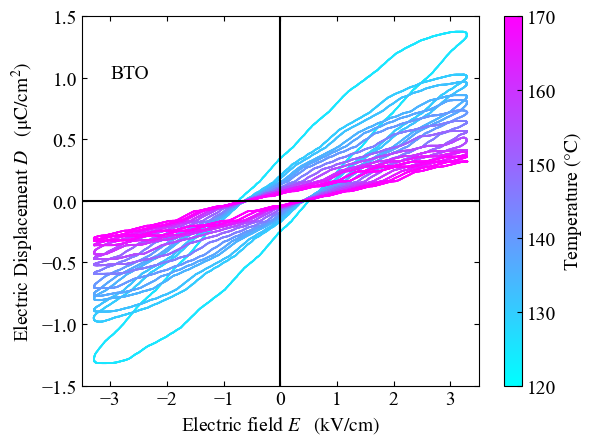

In [28]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-1.5,1.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(68,72):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=120, vmax=170),  s=0.1)
for i in range(72,81):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=120, vmax=170),  s=0.1)
# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()

相転移付近の降温過程

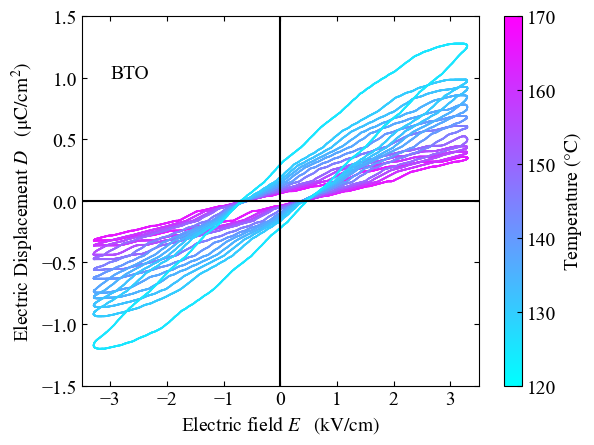

In [29]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-1.5,1.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(81,92):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=120, vmax=170),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()

差分を取ってみる

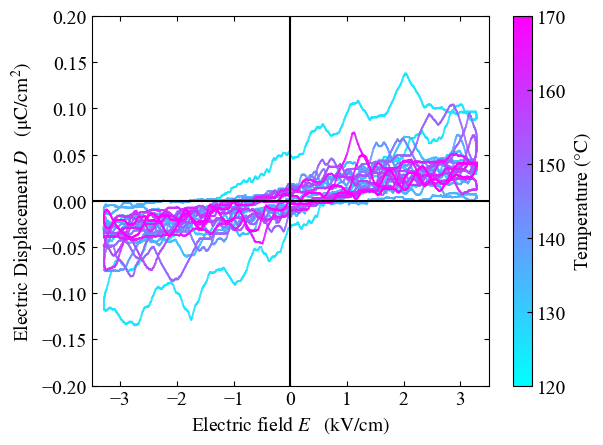

In [30]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-0.2,0.2)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(12):
    plt.scatter(data[68+i][1][3000:7000],data[68+i][2][3000:7000]-data[91-i][2][3000:7000], c=data[68+i][4][3000:7000], cmap="cool", norm=Normalize(vmin=120, vmax=170),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
# plt.text(-3, 1, "BTO")

plt.show()

強誘電体相でのヒステリシス曲線の温度依存性(昇温)

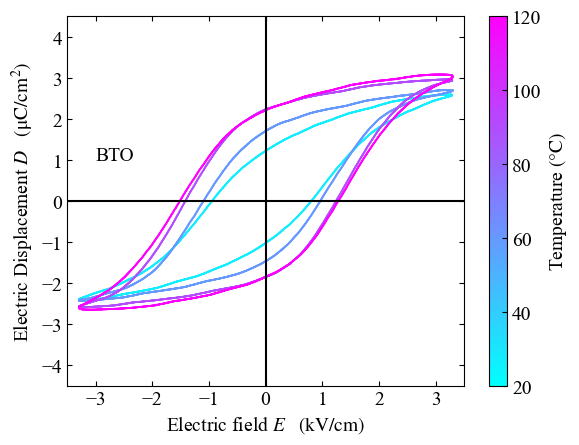

In [31]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-4.5,4.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-4.5,4.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(16,68,17):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=20, vmax=120),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()

強誘電体相でのヒステリシス曲線の温度依存性(降温)

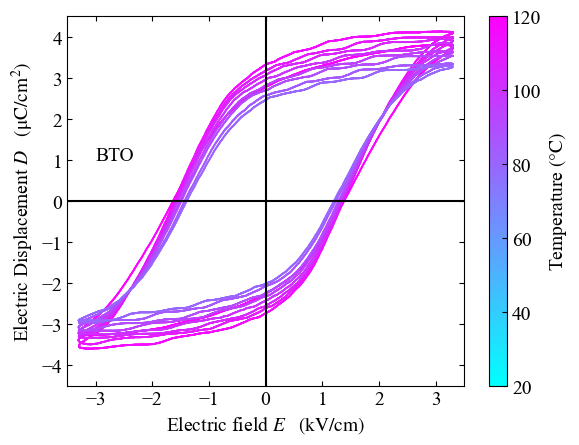

In [32]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-4.5,4.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-4.5,4.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(92,101):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=20, vmax=120),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()

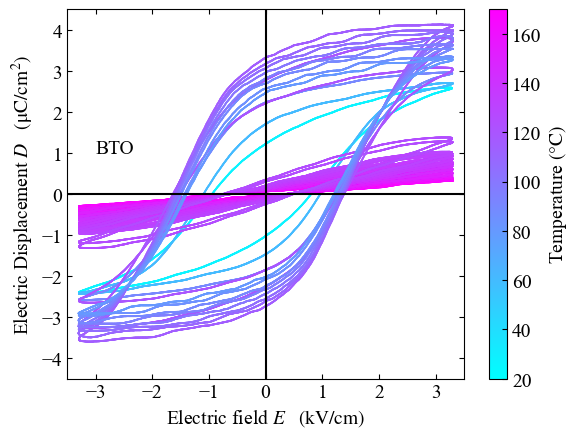

In [35]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-4.5,4.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-4.5,4.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in heating_index:
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=20, vmax=170),  s=0.1)
for i in cooling_index:
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=20, vmax=170),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()

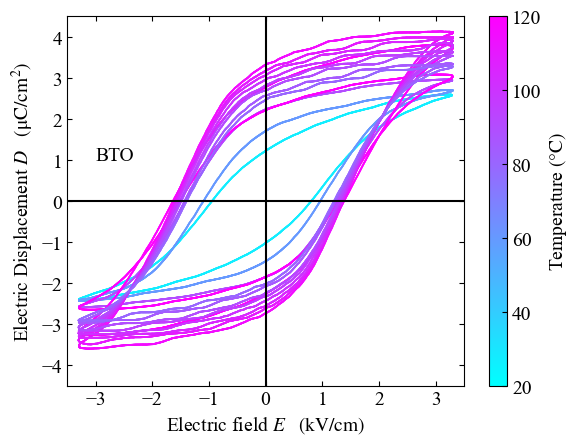

In [37]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-4.5,4.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-4.5,4.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(16,68,17):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=20, vmax=120),  s=0.1)
for i in range(92,101):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=20, vmax=120),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()

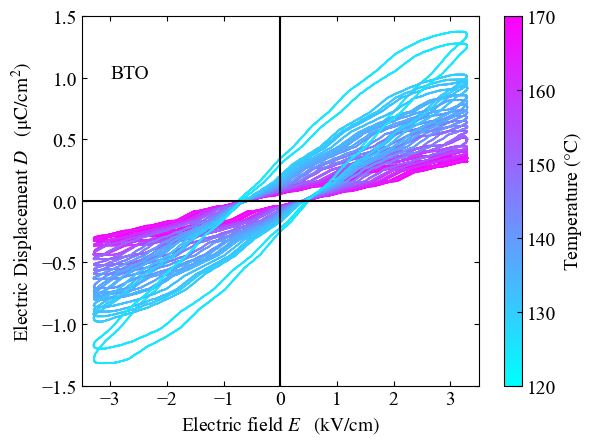

In [38]:
# 目盛を上下作用にセット
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# プロットエリアの範囲等の整備
plt.xlim(-3.5,3.5)
plt.ylim(-1.5,1.5)
plt.xticks([-3,-2,-1,0,1,2,3])
plt.hlines([0],-3.5,3.5, "black")
plt.vlines([0],-3.5,3.5, "black")

# フォントの選択
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] ='Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

# 軸ラベル
plt.xlabel("Electric field $ E \quad\mathrm{(kV/cm)}$")
plt.ylabel("Electric Displacement $ D \quad\mathrm{(\mu C/cm^2)}$ ")

# プロット
for i in range(68,92):
    plt.scatter(data[i][1][3000:7000],data[i][2][3000:7000], c=data[i][4][3000:7000], cmap="cool", norm=Normalize(vmin=120, vmax=170),  s=0.1)

# カラーバーのラベル
plt.colorbar(label = "Temperature $(\mathrm{\degree C})$")

# その他要素
plt.text(-3, 1, "BTO")

plt.show()